In [1]:
import numpy as np
from qiskit.circuit import Gate
from qiskit.circuit.library.standard_gates import CU1Gate, CXGate, HGate, MCXGate, RYGate, RZGate, SwapGate, XGate, ZGate
from qiskit import Aer, ClassicalRegister, execute, QuantumCircuit, QuantumRegister
from qiskit.visualization import plot_histogram
from lib import QFTGate, GroverDiffusionGate, QPEGate

# Introduction

This notebook aims at giving a crash course on **Quantum Amplitude Estimation**, a fundamental quantum algorithm which is the jacknife of many interesting calculations in finance. We will introduce this algorithm in a bottom-up approach, starting from the **Quantum Fourier Transformation**, the **Quantum Phase Estimation**, then detouring by **Grover's algorithm**, before applying all that to **Quantum Amplitude Estimation**.

This presentation does not aim at giving all technical details but rather at conveying a feeling of how these basic building blocks fit together.

# Demos

## Quantum Fourier Transformation

### Background

The **Quantum Fourier Tranformation** (QFT) implements the following operation on the computational basis (the quantum register having $n$ bits):
$$|k\rangle \longmapsto \frac{1}{\sqrt{2^n}}\sum_{0 \leq l < 2^n}\exp\left(-\frac{2\pi ikl}{2^n}\right)|l\rangle$$
It is the quantum analogue of the Discrete Fourier Transform, well-known in signal processing.

In this section, we demonstrate how the QFT can be used to create add a unit to the value of a quantum register, that is, to perform the mapping
$$|k\rangle \longmapsto |k + 1\rangle$$
in the computational basis.
The circuit acts on an $n$-qubits register. We will carry the following steps:
- __Step 1__. Load the value $|k\rangle$ into the register, initially at $|0\rangle$, using a series of $X$ (bit flip) gates. At the end of this step, the register is the state
$$|\psi_1\rangle = |k\rangle$$

- __Step 2__. Apply the QFT to the register. This will take the register to the state:
$$|\psi_2\rangle = \frac{1}{\sqrt{2^n}}\sum_{0 \leq l < 2^n}\exp\left(-\frac{2\pi kl}{2^n}\right)|l\rangle$$

- __Step 3__. Perform a series of single-qubit, $Z$-rotations, acting independently on the qubits and implementing the mapping:
$$|k\rangle \longmapsto \exp\left(-\frac{2\pi ik}{2^n}\right)|k\rangle$$
This will take the state to
$$|\psi_3\rangle = \frac{1}{\sqrt{2^n}}\sum_{0 \leq l < 2^n}\exp\left(-\frac{2\pi i(k + 1)l}{2^n}\right)|l\rangle$$

- __Step 4__. Perform an inverse Fourier transform. This will take the state to:
$$|\psi_4\rangle = |k + 1\rangle$$

### Our example

We illustrate this construction on a quantum register of 4 qubits, containing the value $9_{10} = 1001_2$, which will then be incremented to $10_{10} = 1010_2$ by the algorithm.

#### Step 1: construct a quantum circuit loading $9_{10} = 1001_2$ in a 4-qubit register.

Implement circuit

In [2]:
qr, cr = QuantumRegister(4), ClassicalRegister(4)
qc1 = QuantumCircuit(qr, cr)
qc1.x(qr[0])
qc1.x(qr[3])

Measure circuit

In [3]:
qc = QuantumCircuit(qr, cr)
qc += qc1
qc.measure(qr, cr)

In [4]:
counts = execute(qc, backend=Aer.get_backend("qasm_simulator")).result().get_counts()

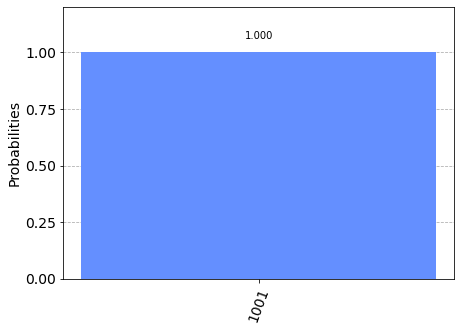

In [5]:
plot_histogram(counts)

#### Step 2: append a QFT circuit to it.

Implement circuit

In [6]:
qc2 = QuantumCircuit(qr, cr)
qc2.append(QFTGate(4), qr)

Measure circuit

In [7]:
qc = QuantumCircuit(qr, cr)
qc = qc1 + qc2
qc.measure(qr, cr)

In [8]:
counts = execute(qc, backend=Aer.get_backend("qasm_simulator"), shots=8192).result().get_counts()

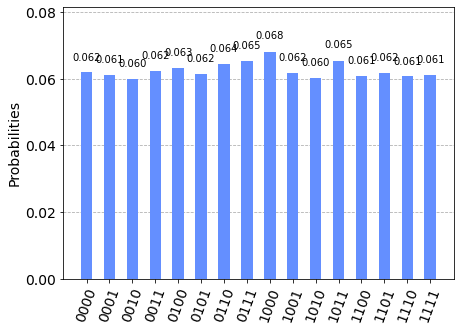

In [9]:
plot_histogram(counts)

#### Step 3: Apply a phase to the qubits and perform an inverse QFT.

First, we apply the unitary defined on the computational basis by
$$U|k\rangle := \exp\left(-\frac{2\pi ik}{2^n}\right)|k\rangle$$

Following this step, the state will be
$$\frac{1}{4}\sum_{0 \leq k < 16}\exp\left(-\frac{2\pi ik}{16}\right)\exp\left(-\frac{2\pi ik}{16}9\right)|k\rangle = \frac{1}{4}\sum_{0 \leq k < 16}\exp\left(-\frac{2\pi ik}{16}10\right)|k\rangle$$

In [10]:
qc3 = QuantumCircuit(qr, cr)
for qubit_index in range(4):
    qc3.rz((2 * np.pi / 2 ** 4) * 2 ** qubit_index, qr[qubit_index])

In [11]:
qc = QuantumCircuit(qr, cr)
qc = qc1 + qc2 + qc3
qc.measure(qr, cr)

In [12]:
counts = execute(qc, backend=Aer.get_backend("qasm_simulator"), shots=8192).result().get_counts()

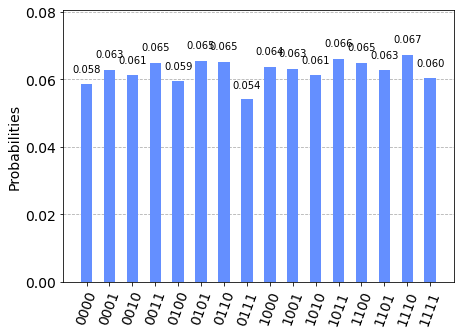

In [13]:
plot_histogram(counts)

#### Step 4: apply an inverse QFT.

We apply an inverse Quantum Fourier Transformation. This will bring the state to
$$|10_{10}\rangle = |1010_2\rangle$$

In [14]:
qc4 = QuantumCircuit(qr, cr)
qc4.append(QFTGate(4).inverse(), qr[:])

In [15]:
qc = QuantumCircuit(qr, cr)
qc = qc1 + qc2 + qc3 + qc4
qc.measure(qr, cr)

In [16]:
counts = execute(qc, backend=Aer.get_backend("qasm_simulator"), shots=8192).result().get_counts()

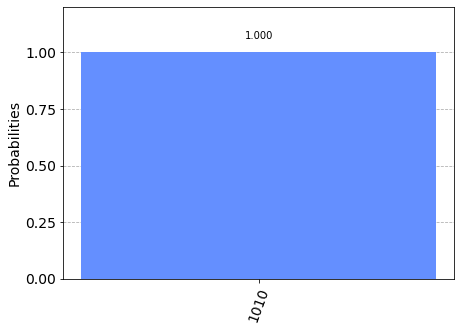

In [17]:
plot_histogram(counts)

## Quantum Phase Estimation

### Background

Given a quantum statevector $|\psi\rangle$ which is an eigenvector of some unitary $U$:
$$U|\psi\rangle = e^{i\varphi}|\psi\rangle$$
the **Quantum Phase Estimation** algorithm allows to estimate $\varphi$ given the access to a quantum circuit implementing $U$ (precisely, controlled-$U$).

The main idea behind the algorithm is that given access to such a circuit, one can systematically (i.e, treating $U$ as a black box) prepare the state:
\begin{align}
    \frac{1}{\sqrt{2^{n_{\textrm{phase}}}}}\sum_{0 \leq k < 2^{n_{\textrm{phase}}}}|k\rangle\left(U^k|\psi\rangle\right) & = \frac{1}{\sqrt{2^{n_{\textrm{phase}}}}}\sum_{0 \leq k < 2^{n_{\textrm{phase}}}}e^{ik\varphi}|k\rangle|\psi\rangle,
\end{align}
where the register containing $k$ in the sum is an $n_{\textrm{phase}}$-qubit register (the notation suggesting that one uses $n_{\textrm{phase}}$ qubits to estimate the phase). The coefficients of the state above are exponentials oscillating with some frequency $\varphi$ -the "phase" to be estimated. This suggests to take the inverse Quantum Fourier Transformation to recover this phase and is indeed what the Quantum Phase Estimation Algorithm does.

### Our example

Our example applies Quantum Phase Estimation to the state $|\psi\rangle := |1\rangle$ and the unitary operator $U := \hat{R}_z(2\theta)$ (qubit $Z$ rotation of angle $2\theta$); the associated eigenvalue is $e^{i\theta}$, corresponding to phase $\theta$.

#### Parameters

In [18]:
theta = 0.43 # The desired phase theta
num_phase_qubits = 4 # The number of qubits in which to encode the phase

#### Declare registers

In [19]:
phase_qr = QuantumRegister(num_phase_qubits)
state_qr = QuantumRegister(1)
phase_cr = ClassicalRegister(num_phase_qubits)

#### Construct the preparing building the state to be estimated

In [20]:
state_preparation_qc = QuantumCircuit(state_qr)
state_preparation_qc.x(state_qr[0])

#### Construct the unitary operator whose phase to estimate

In [21]:
unitary = RZGate(2 * theta)

#### Run Quantum Phase Estimation and interpret the result

In [22]:
qc = QuantumCircuit(phase_qr, state_qr, phase_cr)
qc += state_preparation_qc
qc.append(QPEGate(num_phase_qubits=num_phase_qubits, unitary_gate=unitary), phase_qr[:] + state_qr[:])
qc.measure(phase_qr, phase_cr)

In [23]:
counts = execute(qc, backend=Aer.get_backend("qasm_simulator"), shots=8192).result().get_counts()

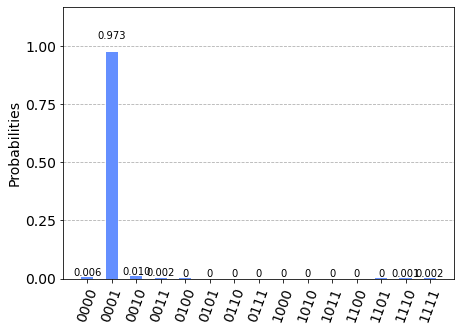

In [24]:
plot_histogram(counts)

In [25]:
argmax_count = max(counts, key=counts.get)
print(f"Estimated phase: {argmax_count} -> {2.0 * np.pi * int(argmax_count, base=2) / 2 ** num_phase_qubits}")

Estimated phase: 0001 -> 0.39269908169872414


## Grover diffusion operator

### Background

Let be given a state $|\psi\rangle$ on $n$ qubits prepared by some algorithm $\mathcal{A}$:
$$|\psi\rangle := \mathcal{A}|0^{\otimes n}\rangle$$
Suppose that this state is an orthogonal combination of a "good" and "bad" part:
\begin{align}
    |\psi\rangle & = |\psi_{\textrm{good}}\rangle + |\psi_{\textrm{bad}}\rangle\\
    \langle\psi_{\textrm{good}}|\psi_{\textrm{bad}}\rangle & = 0\\
    \lVert|\psi_{\textrm{good}}\rangle\rVert^2 & = p\\
    \lVert|\psi_{\textrm{bad}}\rangle\rVert^2 & = 1 - p
\end{align}
One would like to get only the good part, i.e to obtain $\frac{|\psi_{\textrm{good}}\rangle}{\lVert|\psi_{\textrm{good}}\rangle\rVert}$.

In the orthonormal basis $\left\{\frac{|\psi_{\textrm{good}}\rangle}{\lVert \psi_{\textrm{good}} \rVert}, \frac{|\psi_{\textrm{bad}}\rangle}{\lVert \psi_{\textrm{bad}} \rVert}\right\}$, the matrix of the Grover diffusion operator is:
\begin{align}
    \textrm{GroverDiffusion} & = \begin{pmatrix}
        \cos\theta & \sin\theta\\
        -\sin\theta & \cos\theta
    \end{pmatrix}\\
    \sin^2\frac{\theta}{2} & := p
\end{align}
This is a simple rotation matrix in the plane; the angle depends on the probability of the good state $p$.

One can then apply this rotation to $|\psi\rangle := |\psi_{\textrm{good}}\rangle + |\psi_{\textrm{bad}}\rangle$ a certain number of times to rotate it to something close $\frac{|\psi_{\textrm{good}}\rangle}{\lVert|\psi_{\textrm{good}}\rangle\rVert}$.

### Our example

In our example, the algorithm will prepare a state on 4 qubits; the good and bad states will be distinguished by the of their rightmost qubit (index 0). Precisely:
\begin{align}
    |\psi\rangle & = \sqrt{p}|010\rangle|1\rangle + \sqrt{1 - p}|100\rangle|0\rangle\\
    |\psi_{\textrm{good}}\rangle & = \sqrt{p}|010\rangle|1\rangle\\
    |\psi_{\textrm{bad}}\rangle & = \sqrt{1 - p}|100\rangle|0\rangle 
\end{align}

To construct the Grover diffusion operator with the dedicated class, we need to specify an operator $\mathcal{A}$ which prepares $|\psi\rangle$ from $|0000\rangle$:
\begin{align}
    \mathcal{A}|0000\rangle & = \sqrt{p}|010\rangle|1\rangle + \sqrt{1 - p}|100\rangle|0\rangle
\end{align}

Applying the Grover operator repeatedly, we will amplify the "good" state part $\sqrt{p}|010\rangle|1\rangle$

#### Parameters

In [26]:
p = 0.05

#### Declare the qubits

In [27]:
state_qr = QuantumRegister(3)
good_bad_qr = QuantumRegister(1)
auxiliary_qr = QuantumRegister(1)
state_cr = ClassicalRegister(3)
good_bad_cr = ClassicalRegister(1)

#### Construct the state preparation circuit (as a Qiskit `Gate` object)

In [33]:
class StatePreparationGate(Gate):
    def __init__(self, label=None):
        super().__init__(name="StatePreparationGate", num_qubits=4, label=label, params=[])

    def _define(self):
        qr = QuantumRegister(4)
        qc = QuantumCircuit(qr)
        definition = [
            (RYGate(np.arcsin(2 * np.sqrt(p))), [qr[0]], []),
            (CXGate(), [qr[0], qr[2]], []),
            (XGate(), [qr[0]], []),
            (CXGate(), [qr[0], qr[3]], []),
            (XGate(), [qr[0]], [])
        ]
        qc._data = definition
        self.definition = qc

In [34]:
qc = QuantumCircuit(state_qr, good_bad_qr, good_bad_cr, state_cr)
qc.append(StatePreparationGate(), good_bad_qr[:] + state_qr[:])
qc.measure(good_bad_qr, good_bad_cr)
qc.measure(state_qr, state_cr)

In [35]:
counts = execute(qc, backend=Aer.get_backend("qasm_simulator"), shots=8192).result().get_counts()

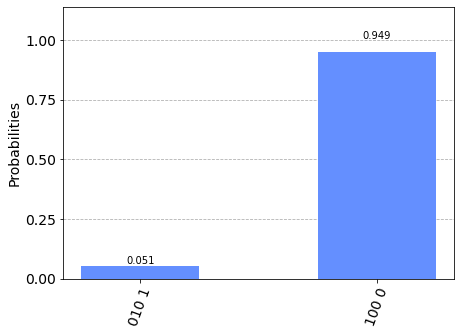

In [36]:
plot_histogram(counts)

#### Construct the Grover diffusion operator from the algorithm circuit

In [37]:
grover_qc = QuantumCircuit(good_bad_qr, state_qr, auxiliary_qr)
grover_gate = GroverDiffusionGate(
    num_qubits=4,
    quantum_algorithm=StatePreparationGate(),
    classical_boolean_oracle=[0, 1],
    oracle_qubits=[0]
)
grover_qc.append(grover_gate, good_bad_qr[:] + state_qr[:] + auxiliary_qr[:])

#### Apply the algorithm circuit, followed by the Grover diffusion circuit a certain number of times

Number of Grover iterations

In [38]:
n_grover = 3

Circuit construction

In [39]:
qc = QuantumCircuit(good_bad_qr, state_qr, good_bad_cr, state_cr)
qc.append(StatePreparationGate(), good_bad_qr[:] + state_qr[:])
for _ in range(n_grover):
    qc += grover_qc
qc.measure(good_bad_qr, good_bad_cr)
qc.measure(state_qr, state_cr)

Quantum register measurement

In [40]:
counts = execute(qc, backend=Aer.get_backend("qasm_simulator"), shots=8192).result().get_counts()

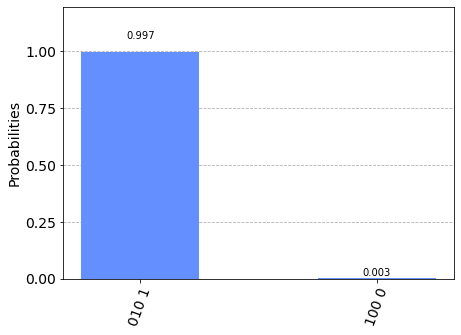

In [41]:
plot_histogram(counts)

## Quantum Amplitude Estimation

### Background

The **Quantum Amplitude Estimation** Algorithm is merely Quantum Phase Estimation applied to the "Grover state" as prepared state:
$$|\psi\rangle := |\psi_{\textrm{good}}\rangle + |\psi_{\textrm{bad}}\rangle$$
and the Grover diffusion operator as unitary operator. It aims at estimating $p := \lVert|\psi_{\textrm{good}}\rangle\rVert^2$, the "probability of the good state".

Recall that in the 2D subspace spanned by $|\psi_{\textrm{good}}\rangle, |\psi_{\textrm{bad}}\rangle$, the matrix of this operator looks like a 2D rotation
$$
\begin{pmatrix}
\cos\theta & \sin\theta\\
-\sin\theta & \cos\theta
\end{pmatrix},
$$
where
$$\sin^2\frac{\theta}{2} = p$$
Such a matrix has 2 eigenvalues $e^{\pm i\theta}$. Therefore, running the Quantum Phase Estimation Algorithm with the Grover state and Grover diffusion operator allows to estimate $\theta$, hence $p$.

In terms of precision, one can estimate $p$ to precision $\varepsilon$ with circuit complexity $\frac{1}{\varepsilon}$. In contrast, classical Monte Carlo would require $\frac{1}{\varepsilon^2}$ steps.

### Our example

To illustrate that, let us come back to our toy Grover state on 4 qubits:
\begin{align}
    |\psi\rangle & = \sqrt{p}|010\rangle|1\rangle + \sqrt{1 - p}|100\rangle|0\rangle\\
    |\psi_{\textrm{good}}\rangle & = \sqrt{p}|010\rangle|1\rangle\\
    |\psi_{\textrm{bad}}\rangle & = \sqrt{1 - p}|100\rangle|0\rangle 
\end{align}

We will implement (again) the circuit constructing this state. Then, we will call Quantum Phase Estimation with this circuit as preparation circuit and the Grover diffusion operator as unitary operator.

#### Parameters

In [42]:
p = 0.27 # The probability of the good state
num_phase_qubits = 4 # The number of qubits in which to encode the phase

#### Declare registers

In [43]:
phase_qr = QuantumRegister(num_phase_qubits)
state_qr = QuantumRegister(3)
good_bad_qr = QuantumRegister(1)
auxiliary_qr = QuantumRegister(1)
phase_cr = ClassicalRegister(num_phase_qubits)

#### Construct the state preparation circuit (as a Qiskit `Gate` object)

In [50]:
class StatePreparationGate(Gate):
    def __init__(self, label=None):
        super().__init__(name="StatePreparationGate", num_qubits=4, label=label, params=[])

    def _define(self):
        qr = QuantumRegister(4)
        qc = QuantumCircuit(qr)
        definition = [
            (RYGate(2 * np.arcsin(np.sqrt(p))), [qr[0]], []),
            (CXGate(), [qr[0], qr[2]], []),
            (XGate(), [qr[0]], []),
            (CXGate(), [qr[0], qr[3]], []),
            (XGate(), [qr[0]], [])
        ]
        qc._data = definition
        self.definition = qc

#### Define the unitary operator on which to perform Quantum Phase Estimation (now, it is the Grover diffusion operator)

In [51]:
qpe_unitary = GroverDiffusionGate(
    num_qubits=4,
    quantum_algorithm=StatePreparationGate(),
    classical_boolean_oracle=[0, 1],
    oracle_qubits=[0]
)

#### Run Quantum Phase Estimation and interpret the result

In [52]:
qc = QuantumCircuit(phase_qr, good_bad_qr, state_qr, auxiliary_qr, phase_cr)
qc.append(StatePreparationGate(), good_bad_qr[:] + state_qr[:])
qc.append(QPEGate(num_phase_qubits=num_phase_qubits, unitary_gate=qpe_unitary), phase_qr[:] + good_bad_qr[:] + state_qr[:] + auxiliary_qr[:])
qc.measure(phase_qr, phase_cr)

In [53]:
counts = execute(qc, backend=Aer.get_backend("qasm_simulator"), shots=8192).result().get_counts()

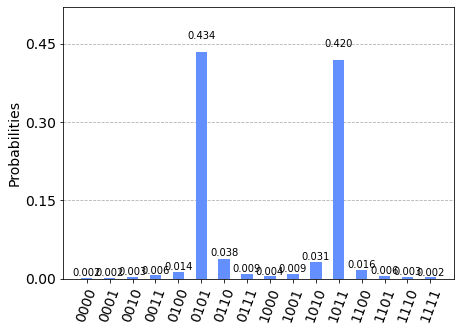

In [54]:
plot_histogram(counts)

In [55]:
argmax_count = max(counts, key=counts.get)
estimated_phase = 2.0 * np.pi * int(argmax_count, base=2) / 2 ** num_phase_qubits
print(f"Estimated phase: {argmax_count} -> {estimated_phase}")
print(f"Corresponding probability: {1 - np.sin(estimated_phase / 2) ** 2}")

Estimated phase: 0101 -> 1.9634954084936207
Corresponding probability: 0.3086582838174551
